## Chapter 11

In [3]:
import numpy as np
import control
import matplotlib.pyplot as plt

### Notes
Most of these problems are repetitive and use examples from all of the previous chapters, which I have already worked.  Therefore, I am only going to work a few problems that tie the following concepts together

* Kalman filter design
* compensator design

#### a)
For comparison, the steady-state matrix Riccati equation from LQR chapter was
\begin{eqnarray}
0 = \bar M A + A^T \bar M - \bar M B R^{-1} B^T \bar M + Q,
\end{eqnarray}
which leads to optimal gain matrix $\bar G = R^{-1} B^T \bar M$.

For this chapter, the steady-state _covariance_ equation is
\begin{eqnarray}
0 = \bar P A^T + A \bar P - \bar P C^T W^{-1} C \bar P + FVF^{T},
\end{eqnarray}
with $V, W$ the process and measurement noise matrices, respectively.  The Kalman gain matrix is then $\bar K = \bar P C^T W^{-1}$.

The Kalman observer problem is _dual_ to the LQR problem, with $A \to A^T$, $B \to C^T$, $Q \to FVF^T$, and $R \to W$.

#### b)
The closed-loop system defined by the second solution in part a) is $A^T - C^TK^T$, where $K^T$ is the LQR solution to `lqr(A.T, C.T, FVF^T, W)`.  Observe that $A^T-C^TK^T = (A - KC)^T$.  From this fact, it follows that the eigenvalues \( poles \) of $A-KC$ will be the same as those found in the return for `lqr(A.T, C.T, FVF^T, W)`.

### Problem 11.1
####  a)

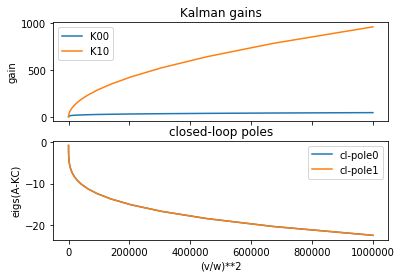

In [64]:
alp, bet = 1., 3.
A = np.array([[0, 1], [0, -alp]]).astype('float').reshape((2, 2))
B = np.array([[0], [bet]]).astype('float').reshape((2, 1))
C = np.array([[1, 0]]).astype('float').reshape((1, 2))
D = np.zeros((1, 1)).astype('float')
F = np.array([[0, 0], [0, 1]]).astype('float')
v2_over_w2 = np.logspace(0, 6, num=36, base=10)
# sample to get the sizing right
KT, _, _ = control.lqr(A.T, C.T, v2_over_w2[0]*F@F.T, 1)
kalman_poles = np.empty((v2_over_w2.size, A.shape[0])).astype('complex')
rows_K, cols_K = (KT.T).shape
kalman_gains = np.empty((v2_over_w2.size, rows_K, cols_K)).astype('float')
for i,_v in enumerate(v2_over_w2):
    KT, _, E = control.lqr(A.T, C.T, _v*F@F.T, 1)
    kalman_gains[i, :, :] = KT.T
    kalman_poles[i, :] = np.sort(E) # sort from smallest to largest
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
for i in range(kalman_gains.shape[1]):
    for j in range(kalman_gains.shape[2]):
        ax1.plot(v2_over_w2, kalman_gains[:, i, j], label='K{}{}'.format(i, j))
for i in range(kalman_poles.shape[1]):
    ax2.plot(v2_over_w2, kalman_poles[:, i], label='cl-pole{}'.format(i))
ax1.legend()
ax1.set_title('Kalman gains')
ax1.set_ylabel('gain')
ax2.legend()
ax2.set_title('closed-loop poles')
ax2.set_ylabel('eigs(A-KC)')
ax2.set_xlabel('(v/w)**2')
f.show()

The system becomes more stable for increasing Kalman gain.  This intuitively makes sense, since the gain is being applied to the unmeasured state $\omega$.

#### b)

In [82]:
alp, bet = 1., 3.
A = np.array([[0, 1], [0, -alp]]).astype('float').reshape((2, 2))
B = np.array([[0], [bet]]).astype('float').reshape((2, 1))
C = np.array([[1, 0]]).astype('float').reshape((1, 2))
D = np.zeros((1, 1)).astype('float')
F = np.array([[0, 0], [0, 1]]).astype('float')
# hold V fixed and then scale W
v = 1.
W = np.logspace(0, 5, num=6, base=2)
q1 = np.array([1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]).astype('float')
R = np.array([[1]]).astype('float').reshape((1, 1))
k = np.logspace(-2., 6., num=25, base=2)
for i,_q in enumerate(q1):
    print('##### q = {} #####'.format(_q))
    Q = np.array([[_q**2, 0], [0, 0]]).astype('float').reshape((2, 2))
    G, _, _ = control.lqr(A, B, Q, R)
    for w in W:
        print('  V/W={}'.format(w**-1))
        KT, _, _ = control.lqr(A.T, C.T, v*F@F.T, w)
        K = KT.T
        Abarc = A - B@G - K@C
        sysD = control.StateSpace(Abarc, K, G, np.zeros((1, 1)))
        tfD = control.ss2tf(sysD)
        sysplant = control.StateSpace(A, B, C, np.zeros((1, 1)))
        tfplant = control.ss2tf(sysplant)
        # now find range of gain variation
        stable = np.zeros_like(k)
        for _i,_k in enumerate(k):
            rz = np.real(control.zero(1.+(_k*tfD)*tfplant))
            if rz.size > 0 and np.max(rz) < 0:
                stable[_i] = 1.
        ids = np.argwhere(stable>0)
        print('  stable loop-gain range=({lb}, {ub})'.format(lb=k[ids[0]][0], ub=k[ids[-1]][0]))

##### q = 0.001 #####
  V/W=1.0
  stable loop-gain range=(0.25, 64.0)
  V/W=0.5
  stable loop-gain range=(0.25, 64.0)
  V/W=0.25
  stable loop-gain range=(0.25, 64.0)
  V/W=0.125
  stable loop-gain range=(0.25, 64.0)
  V/W=0.0625
  stable loop-gain range=(0.25, 64.0)
  V/W=0.03125
  stable loop-gain range=(0.25, 64.0)
##### q = 0.01 #####
  V/W=1.0
  stable loop-gain range=(0.25, 50.796833662982365)
  V/W=0.5
  stable loop-gain range=(0.25, 50.796833662982365)
  V/W=0.25
  stable loop-gain range=(0.25, 50.796833662982365)
  V/W=0.125
  stable loop-gain range=(0.25, 40.317473596635935)
  V/W=0.0625
  stable loop-gain range=(0.25, 40.317473596635935)
  V/W=0.03125
  stable loop-gain range=(0.25, 40.317473596635935)
##### q = 0.1 #####
  V/W=1.0
  stable loop-gain range=(0.25, 8.0)
  V/W=0.5
  stable loop-gain range=(0.25, 8.0)
  V/W=0.25
  stable loop-gain range=(0.25, 10.079368399158984)
  V/W=0.125
  stable loop-gain range=(0.25, 10.079368399158984)
  V/W=0.0625
  stable loop-gain rang

These gain stability margins are really terrific given the results of Chapter 8: recall Problems 8.4, _et al_. The last result above means that, with $q=1000$, the closed-loop system is stable over the _full_ range of $V/W$ _and_ with loop-gain ranging from $1/4$ to $64$.

### Problem 11.2
#### a)

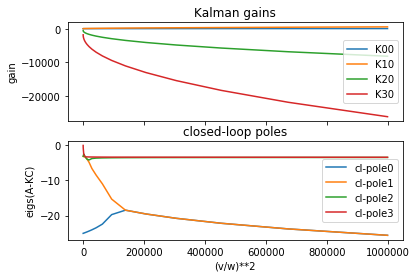

In [78]:
# using constants from Problem 3.6
m, M, l, g, k, R, r = .1, 1., 1., 9.8, 1., 100., .02
A = np.array([[0., 1., 0., 0.], 
              [0., -k**2 / (M*r**2*R), -(m*g)/M, 0.], 
              [0., 0., 0., 1.], 
              [0, k**2 / (M*r**2*R*l), ((M+m)*g)/(M*l), 0.]])
C = np.array([[1., 0., 0., 0.]]).reshape((1, 4))
F = np.array([[0.], [1.], [0.], [1.]])
v2_over_w2 = np.logspace(0, 6, num=36, base=10)
# sample to get the sizing right
KT, _, _ = control.lqr(A.T, C.T, v2_over_w2[0]*F@F.T, 1)
kalman_poles = np.empty((v2_over_w2.size, A.shape[0])).astype('complex')
rows_K, cols_K = (KT.T).shape
kalman_gains = np.empty((v2_over_w2.size, rows_K, cols_K)).astype('float')
for i,_v in enumerate(v2_over_w2):
    KT, _, E = control.lqr(A.T, C.T, _v*F@F.T, 1)
    kalman_gains[i, :, :] = KT.T
    kalman_poles[i, :] = np.sort(E) # sort from smallest to largest
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
for i in range(kalman_gains.shape[1]):
    for j in range(kalman_gains.shape[2]):
        ax1.plot(v2_over_w2, kalman_gains[:, i, j], label='K{}{}'.format(i, j))
for i in range(kalman_poles.shape[1]):
    ax2.plot(v2_over_w2, kalman_poles[:, i], label='cl-pole{}'.format(i))
ax1.legend()
ax1.set_title('Kalman gains')
ax1.set_ylabel('gain')
ax2.legend()
ax2.set_title('closed-loop poles')
ax2.set_ylabel('eigs(A-KC)')
ax2.set_xlabel('(v/w)**2')
f.show()

#### b)

In [79]:
Q = np.array([[100, 0, 0, 0], [0, 0, 0, 0], [0, 0, 3000, 0], [0, 0, 0, 0]]).astype('float').reshape((4, 4))
B = np.array([[0.], [k/(M*R*r)], [0.], [-k/(M*R*r*l)]])
r2 = np.array([[1e-2]])
G, _, _ = control.lqr(A, B, Q, r2)
for i,_v in enumerate(v2_over_w2):
    KT, _, E = control.lqr(A.T, C.T, _v*F@F.T, 1)
    K = KT.T
    Abarc = A - B@G - K@C
    sysD = control.StateSpace(Abarc, K, G, np.zeros((1, 1)))
    print('##### (v/w)**2 = {} #####'.format(_v))
    print('  compensator transfer function: {}'.format(control.ss2tf(sysD)))
    print('  compensator poles: {}\n'.format(control.pole(sysD)))

##### (v/w)**2 = 1.0 #####
  compensator transfer function: 
  8.912e+05 s^3 + 2.508e+07 s^2 + 6.936e+07 s - 1176
-----------------------------------------------------
s^4 + 43.71 s^3 + 631.9 s^2 - 4.417e+05 s - 1.388e+06

  compensator poles: [-51.79948992+65.95931221j -51.79948992-65.95931221j
  63.02100749 +0.j          -3.13050128 +0.j        ]

##### (v/w)**2 = 1.4839817889675653 #####
  compensator transfer function: 
  8.941e+05 s^3 + 2.517e+07 s^2 + 6.958e+07 s - 1433
-----------------------------------------------------
s^4 + 43.72 s^3 + 632.4 s^2 - 4.431e+05 s - 1.392e+06

  compensator poles: [-51.84408958+66.03198007j -51.84408958-66.03198007j
  63.09980583 +0.j          -3.13050136 +0.j        ]

##### (v/w)**2 = 2.202201949987375 #####
  compensator transfer function: 
  8.976e+05 s^3 + 2.527e+07 s^2 + 6.986e+07 s - 1745
-----------------------------------------------------
s^4 + 43.73 s^3 + 632.9 s^2 - 4.449e+05 s - 1.398e+06

  compensator poles: [-51.89826297+66.120234

We can see that, indeed, there are poles that lie along the real-axis in the right-plane; i.e. the compensator is an unstable system.

#### c)

In [81]:
v2_over_w2 = 1e-3
KT, _, _ = control.lqr(A.T, C.T, v2_over_w2*F@F.T, 1)
K = KT.T
r2 = np.array([[1e-2]])
G, _, _ = control.lqr(A, B, Q, r2)
Abarc = A - B@G - K@C
sysD = control.StateSpace(Abarc, K, G, np.zeros((1, 1)))
tfD = control.ss2tf(sysD)
sysplant = control.StateSpace(A, B, C, np.zeros((1, 1)))
tfplant = control.ss2tf(sysplant)
# now find range of gain variation
k = np.linspace(0.998, 1.002, num=101)
stable = np.zeros_like(k)
for _i,_k in enumerate(k):
    rz = np.real(control.zero(1.+(_k*tfD)*tfplant))
    if rz.size > 0 and np.max(rz) < 0:
        stable[_i] = 1.
ids = np.argwhere(stable>0)
print('stable loop-gain range=({lb}, {ub})'.format(lb=k[ids[0]][0], ub=k[ids[-1]][0]))

stable loop-gain range=(0.99892, 1.00032)


### Problem 11.3
#### a)

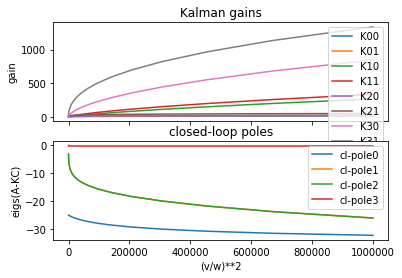

In [91]:
# using constants from Problem 3.6
m, M, l, g, k, R, r = .1, 1., 1., 9.8, 1., 100., .02
A = np.array([[0., 1., 0., 0.], 
              [0., -k**2 / (M*r**2*R), -(m*g)/M, 0.], 
              [0., 0., 0., 1.], 
              [0, k**2 / (M*r**2*R*l), ((M+m)*g)/(M*l), 0.]])
C = np.array([[1., 0., 0., 0.], [0., 0., 1., 0.]]).reshape((2, 4))
F = np.array([[0.], [1.], [0.], [1.]])
# normalize so that w**2=1
v2_over_w2 = np.logspace(0, 6, num=36, base=10)
# sample to get the sizing right
KT, _, _ = control.lqr(A.T, C.T, v2_over_w2[0]*F@F.T, np.eye(2))
kalman_poles = np.empty((v2_over_w2.size, A.shape[0])).astype('complex')
rows_K, cols_K = (KT.T).shape
kalman_gains = np.empty((v2_over_w2.size, rows_K, cols_K)).astype('float')
for i,_v in enumerate(v2_over_w2):
    KT, _, E = control.lqr(A.T, C.T, _v*F@F.T, np.eye(2))
    kalman_gains[i, :, :] = KT.T
    kalman_poles[i, :] = np.sort(E) # sort from smallest to largest
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
for i in range(kalman_gains.shape[1]):
    for j in range(kalman_gains.shape[2]):
        ax1.plot(v2_over_w2, kalman_gains[:, i, j], label='K{}{}'.format(i, j))
for i in range(kalman_poles.shape[1]):
    ax2.plot(v2_over_w2, kalman_poles[:, i], label='cl-pole{}'.format(i))
ax1.legend()
ax1.set_title('Kalman gains')
ax1.set_ylabel('gain')
ax2.legend()
ax2.set_title('closed-loop poles')
ax2.set_ylabel('eigs(A-KC)')
ax2.set_xlabel('(v/w)**2')
f.show()

#### b)
No, it is not possible to achieve a stable compensator.  The results below show that the poles are moved significantly closer to the imaginary axis \($~63 \to (<1)$\), but they are still in the right-half plane.

In [92]:
Q = np.array([[100, 0, 0, 0], [0, 0, 0, 0], [0, 0, 3000, 0], [0, 0, 0, 0]]).astype('float').reshape((4, 4))
B = np.array([[0.], [k/(M*R*r)], [0.], [-k/(M*R*r*l)]])
r2 = np.array([[1e-2]])
G, _, _ = control.lqr(A, B, Q, r2)
#v2_over_w2 = np.linspace(50, 75, num=26)  # at about v**2/w**2 poles around re(s)~0.84 become part of complex conjugate pair 
for i,_v in enumerate(v2_over_w2):
    KT, _, E = control.lqr(A.T, C.T, _v*F@F.T, np.eye(2))
    K = KT.T
    Abarc = A - B@G - K@C
    sysD = control.StateSpace(Abarc, K, G, np.zeros((1, 2)))
    print('##### (v/w)**2 = {} #####'.format(_v))
    print('  compensator transfer function: {}'.format(control.ss2tf(sysD)))
    print('  compensator poles: {}\n'.format(control.pole(sysD)))

##### (v/w)**2 = 1.0 #####
  compensator transfer function: 
Input 1 to output 1:
    82.63 s^3 + 2271 s^2 + 4995 s - 1176
--------------------------------------------
s^4 + 43.74 s^3 + 633.3 s^2 - 1029 s - 648.9

Input 2 to output 1:
-9780 s^3 - 2.758e+05 s^2 - 7.745e+05 s - 3.553e+04
---------------------------------------------------
    s^4 + 43.74 s^3 + 633.3 s^2 - 1029 s - 648.9

  compensator poles: [-22.57672465+13.72435062j -22.57672465-13.72435062j
   1.90261177 +0.j          -0.4885452  +0.j        ]

##### (v/w)**2 = 1.4839817889675653 #####
  compensator transfer function: 
Input 1 to output 1:
    72.78 s^3 + 1971 s^2 + 3661 s - 1433
--------------------------------------------
s^4 + 43.76 s^3 + 634.4 s^2 - 1026 s - 637.5

Input 2 to output 1:
-9814 s^3 - 2.768e+05 s^2 - 7.801e+05 s - 4.298e+04
---------------------------------------------------
    s^4 + 43.76 s^3 + 634.4 s^2 - 1026 s - 637.5

  compensator poles: [-22.58648257+13.73949331j -22.58648257-13.73949331j
   1

#### c)

In [148]:
v2_over_w2 = 1e5
KT, _, _ = control.lqr(A.T, C.T, v2_over_w2*F@F.T, np.eye(2))
K = KT.T
r2 = np.array([[1e-2]])
G, _, _ = control.lqr(A, B, Q, r2)
Abarc = A - B@G - K@C
sysD = control.StateSpace(Abarc, K, G, np.zeros((1, 2)))
tfD = control.ss2tf(sysD)
sysplant = control.StateSpace(A, B, C, np.zeros((2, 1)))
tfplant = control.ss2tf(sysplant)
rd = 1.+control.series(tfD, tfplant)
ssrd = control.tf2ss(rd)
# how big is this?  Is it even worth going through the rest of this?
print(ssrd.A.shape)

(30, 30)


The return difference transfer is $2 \times 2$, which makes the problem more complicated.  Instead of finding the zeros of the SISO transfer function as I've done previously, I'd need to find the _transmission_ zeros of the process.  Because the state-space model of the return-difference is so big \(30-by-30\), I'm not going to do the whole thing.  I will instead outline the method of solution.

Once a state-space model of the return-difference is found, we can find the transmission zeros by the method discussed in these [lecture notes from MIT](https://ocw.mit.edu/courses/electrical-engineering-and-computer-science/6-241j-dynamic-systems-and-control-spring-2011/readings/MIT6_241JS11_chap27.pdf) \(see Example 27.4\):

Compute the determinant of the matrix:
\begin{eqnarray}
\bar D = \begin{pmatrix}
sI-A & -B \\
C & D
\end{pmatrix}
\end{eqnarray}
and find the values for $s$ where $\det(\bar D) = 0$.

This procedure would need to be done in a loop over loop-gain $K$.

I think that the `python-control` library is probably not doing a good job of simplifying the return-difference, but I don't want to dig any deeper for this problem.

### Problem 11.4
#### a)

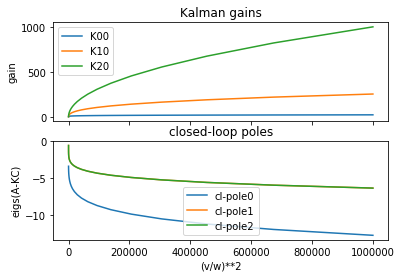

In [149]:
A = np.array([[-1, 1, 0], [1, -3, 2], [0, 0, 0]]).astype('float')
B = np.array([[1], [0], [0]]).astype('float')
C = np.array([[1, 0, 0]]).astype('float')
F = np.array([[0], [0], [1]]).astype('float')
v2_over_w2 = np.logspace(0, 6, num=36, base=10)
# sample to get the sizing right
KT, _, _ = control.lqr(A.T, C.T, v2_over_w2[0]*F@F.T, 1)
kalman_poles = np.empty((v2_over_w2.size, A.shape[0])).astype('complex')
rows_K, cols_K = (KT.T).shape
kalman_gains = np.empty((v2_over_w2.size, rows_K, cols_K)).astype('float')
for i,_v in enumerate(v2_over_w2):
    KT, _, E = control.lqr(A.T, C.T, _v*F@F.T, 1)
    kalman_gains[i, :, :] = KT.T
    kalman_poles[i, :] = np.sort(E) # sort from smallest to largest
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
for i in range(kalman_gains.shape[1]):
    for j in range(kalman_gains.shape[2]):
        ax1.plot(v2_over_w2, kalman_gains[:, i, j], label='K{}{}'.format(i, j))
for i in range(kalman_poles.shape[1]):
    ax2.plot(v2_over_w2, kalman_poles[:, i], label='cl-pole{}'.format(i))
ax1.legend()
ax1.set_title('Kalman gains')
ax1.set_ylabel('gain')
ax2.legend()
ax2.set_title('closed-loop poles')
ax2.set_ylabel('eigs(A-KC)')
ax2.set_xlabel('(v/w)**2')
f.show()

#### b)
The compensated process is _very_ robust.  Look at these margins:

In [158]:
# values from Pg. 358 for k=10**-2
G = np.array([[99.02, 0.9628, 2.5e-2]])
k = np.logspace(-2., 10., num=10, base=2)
for _v in v2_over_w2:
    print('  V/W={}'.format(_v))
    KT, _, _ = control.lqr(A.T, C.T, _v*F@F.T, 1)
    K = KT.T
    Abarc = A - B@G - K@C
    sysD = control.StateSpace(Abarc, K, G, np.zeros((1, 1)))
    tfD = control.ss2tf(sysD)
    sysplant = control.StateSpace(A, B, C, np.zeros((1, 1)))
    tfplant = control.ss2tf(sysplant)
    # now find range of gain variation
    stable = np.zeros_like(k)
    for _i,_k in enumerate(k):
        rz = np.real(control.zero(1.+(_k*tfD)*tfplant))
        if rz.size > 0 and np.max(rz) < 0:
            stable[_i] = 1.
    ids = np.argwhere(stable>0)
    print('  stable loop-gain range=({lb}, {ub})'.format(lb=k[ids[0]][0], ub=k[ids[-1]][0]))

  V/W=1.0
  stable loop-gain range=(0.25, 1024.0)
  V/W=1.4839817889675653
  stable loop-gain range=(0.25, 1024.0)
  V/W=2.202201949987375
  stable loop-gain range=(0.25, 1024.0)
  V/W=3.268027589410125
  stable loop-gain range=(0.25, 1024.0)
  V/W=4.849693428528198
  stable loop-gain range=(0.25, 1024.0)
  V/W=7.196856730011521
  stable loop-gain range=(0.25, 1024.0)
  V/W=10.680004325145754
  stable loop-gain range=(0.25, 1024.0)
  V/W=15.848931924611133
  stable loop-gain range=(0.25, 1024.0)
  V/W=23.51952635070959
  stable loop-gain range=(0.25, 1024.0)
  V/W=34.90254878959581
  stable loop-gain range=(0.25, 1024.0)
  V/W=51.794746792312125
  stable loop-gain range=(0.25, 1024.0)
  V/W=76.86246100397739
  stable loop-gain range=(0.25, 1024.0)
  V/W=114.06249238513203
  stable loop-gain range=(0.25, 1024.0)
  V/W=169.26666150378762
  stable loop-gain range=(0.25, 1024.0)
  V/W=251.18864315095797
  stable loop-gain range=(0.25, 1024.0)
  V/W=372.7593720314942
  stable loop-gain rang

### Problem 11.5
This problem was pretty interesting because of the numerical conditioning issue that arose.  I suspect the issue is internal to how slycot, which is in Fortran, does eigenvalue checking.  There appears to be a pole very near 0, which makes sense given the structure of the metasystem; i.e. the zero rows in $A_m$ give rise to poles along the imaginary axis.

#### a)

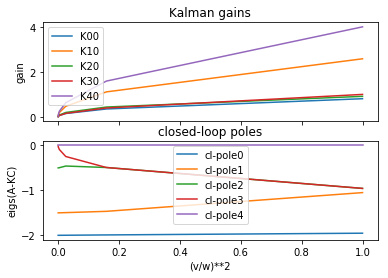

In [221]:
_R, _C = 2., 1.  # don't confuse the R-resistance, C-capacitance with R,C matrices!
A = np.array([[-3./(_R*_C), 1./(_R*_C), 0.],[1./(_R*_C), -2./(_R*_C), 1./(_R*_C)], [0., 1./(_R*_C), -3./(_R*_C)]])
B = np.array([[2. / (_R*_C)], [0.], [0.]])
C = np.array([[0, 0, 1]]).astype('float').reshape((1, 3))
E = np.array([[0., 0.], [0., 1./(_R*_C)], [-3./(_R*_C), 1./(_R*_C)]])
F = np.eye(2)
Am = np.vstack([np.hstack([A, E]), np.zeros((E.shape[1], A.shape[1] + E.shape[1]))])
Bm = np.vstack([B, np.zeros((E.shape[1], B.shape[1]))])
Cm = np.hstack([C, np.zeros((C.shape[0], E.shape[1]))])
Fm = np.zeros((Am.shape[0], E.shape[1]))
Fm[A.shape[0]:, :] = F
v2_over_w2 = np.logspace(-4, 0, num=6, base=10)
Am[-1, -1] = 1e-6  # add some small noise to condition the matrix, otherwise all hell breaks loose with the slycot solver
# sample to get the sizing right
KT, _, _ = control.lqr(Am.T, Cm.T, Fm@Fm.T, 1)
kalman_poles = np.empty((v2_over_w2.size, Am.shape[0])).astype('complex')
rows_K, cols_K = (KT.T).shape
kalman_gains = np.empty((v2_over_w2.size, rows_K, cols_K)).astype('float')
for i,_v in enumerate(v2_over_w2):
    KT, _, _E = control.lqr(Am.T, Cm.T, _v*Fm@Fm.T, 1)
    kalman_gains[i, :, :] = KT.T
    kalman_poles[i, :] = np.sort(_E) # sort from smallest to largest
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
for i in range(kalman_gains.shape[1]):
    for j in range(kalman_gains.shape[2]):
        ax1.plot(v2_over_w2, kalman_gains[:, i, j], label='K{}{}'.format(i, j))
for i in range(kalman_poles.shape[1]):
    ax2.plot(v2_over_w2, kalman_poles[:, i], label='cl-pole{}'.format(i))
ax1.legend()
ax1.set_title('Kalman gains')
ax1.set_ylabel('gain')
ax2.legend()
ax2.set_title('closed-loop poles')
ax2.set_ylabel('eigs(A-KC)')
ax2.set_xlabel('(v/w)**2')
f.show()

#### b)

In [222]:
Q = np.zeros_like(A).astype('float')
Q[2, 2] = 1
r2 = [1e-6, 1e-4, 1e-2]
v2_over_w2 = [1e-4, 1e-2, 1.]
for _r2 in r2:
    # solve for control gains
    print('##### Control Weighting: {} #####'.format(_r2))
    R = np.array([[_r2]]).astype('float').reshape((1, 1))
    Glqr, _, _ = control.lqr(A, B, Q, R)
    Glqr.reshape((1, A.shape[0]))
    Ac = A-B@Glqr
    CAinv = C@np.linalg.inv(Ac)
    Bpound = np.linalg.pinv(CAinv@B)@CAinv
    G0 = Bpound@E  # use G0#, not G0*!  see Ch.9 for more details
    Gm = np.hstack([Glqr, G0])
    # solve for observer gains
    for _v in v2_over_w2:
        print('  +++ Signal-to-Noise ratio: {} +++'.format(_v))
        KT, _, _ = control.lqr(Am.T, Cm.T, _v*Fm@Fm.T, 1)
        K = KT.T
        Abarc = Am - Bm@Gm - K@Cm
        sysD = control.StateSpace(Abarc, K, Gm, np.zeros((1, 1)))
        tfD = control.ss2tf(sysD)
        print('    compensator transfer function = {}'.format(tfD))

##### Control Weighting: 1e-06 #####
  +++ Signal-to-Noise ratio: 0.0001 +++
    compensator transfer function = 
     14.05 s^4 + 56.29 s^3 + 66.99 s^2 + 21.25 s + 1.875e-05
-----------------------------------------------------------------
s^5 + 12.96 s^4 + 80.69 s^3 + 251.1 s^2 - 0.0002509 s + 1.004e-17

  +++ Signal-to-Noise ratio: 0.01 +++
    compensator transfer function = 
    132.3 s^4 + 535.3 s^3 + 647.5 s^2 + 212.5 s + 0.0001875
----------------------------------------------------------------
s^5 + 13.07 s^4 + 82.2 s^3 + 260.6 s^2 - 0.0002582 s - 1.044e-17

  +++ Signal-to-Noise ratio: 1.0 +++
    compensator transfer function = 
        1027 s^4 + 4404 s^3 + 5746 s^2 + 2125 s + 0.001876
-----------------------------------------------------------------
s^5 + 13.86 s^4 + 92.77 s^3 + 328.6 s^2 - 0.0003047 s + 3.456e-17

##### Control Weighting: 0.0001 #####
  +++ Signal-to-Noise ratio: 0.0001 +++
    compensator transfer function = 
     1.41 s^4 + 5.647 s^3 + 6.717 s^2 + 2.129

### Problem 11.21
Let's start with the LQR design setup:  When a gain $G$ is found that minimizes the performance criterion:
\begin{eqnarray}
V = \int_{-\infty}^\infty \mathbf{x}^T Q \mathbf{x} + \mathbf{u}^T R \mathbf{u} d \tau,
\end{eqnarray}
$G$ also minimizes
\begin{eqnarray}
\alpha V = \int_{-\infty}^\infty \mathbf{x}^T (\alpha Q) \mathbf{x} + \mathbf{u}^T (\alpha R) \mathbf{u} d \tau.
\end{eqnarray}
This means that the gain $G$ does not change under scaling of the performance integral.  The gain is $G = R^{-1} B M$ which, by necessity, must also equal $\alpha^{-1}R^{-1}B \bar M$, where $\bar M$ solves the scaled Riccati equation.  $\bar M$ must be linearly scaled by $\alpha$ to make sure the necessary equalities hold.  The takeaway: although the gain $G$ is unchanged, the solution $M$ to the scaled Riccati equation is different.

Now, we can use the dual nature of the Kalman filter problem to the LQR problem \(see *Notes* section above\), which gives us the desired conclusion _for free_!